In [8]:
import pandas as pd
from scipy.stats import wilcoxon
import numpy as np
from scipy import stats
from dieboldmariano import dm_test

In [9]:
df_lstm = pd.read_csv('lstm_baseline.csv')

print(df_lstm.head())

         Date    Actual  Predicted
0  2014-01-24  0.006968   0.005303
1  2014-01-27  0.006996   0.006565
2  2014-01-28  0.007142   0.007071
3  2014-01-29  0.007384   0.007284
4  2014-01-30  0.007886   0.007557


In [11]:
df_sv = pd.read_csv('sv_predictions_1day.csv')
#df2['Training_End'] = pd.to_datetime(df2['Training_End'], format='%d/%m/%Y')
df_sv.set_index('Training_End', inplace=True)

df_sv = df_sv.loc["2014-01-24":]
print(df_sv.head())

             Training_Start Prediction_Date  SV_Volatility
Training_End                                              
2014-01-24       2012-01-24      2014-01-27       0.006596
2014-01-27       2012-01-25      2014-01-28       0.008759
2014-01-28       2012-01-26      2014-01-29       0.007804
2014-01-29       2012-01-27      2014-01-30       0.007606
2014-01-30       2012-01-30      2014-01-31       0.007602


In [12]:
df_lstm = df_lstm.reset_index()

# Merge df1 and df2, aligning df1.Date with df2.Prediction_Date
merged_df = pd.merge(df_lstm, df_sv, 
                     left_on='Date', 
                     right_on='Training_End', 
                     how='left')  # 'outer' keeps all dates; use 'left' or 'right' if preferred

# Drop redundant 'Prediction_Date' column (same as 'Date')
#merged_df = merged_df.drop(columns=['Training_End'])

# Optionally set 'Date' back as index
merged_df = merged_df.set_index('Date')

print(merged_df)

            index    Actual  Predicted Training_Start Prediction_Date  \
Date                                                                    
2014-01-24      0  0.006968   0.005303     2012-01-24      2014-01-27   
2014-01-27      1  0.006996   0.006565     2012-01-25      2014-01-28   
2014-01-28      2  0.007142   0.007071     2012-01-26      2014-01-29   
2014-01-29      3  0.007384   0.007284     2012-01-27      2014-01-30   
2014-01-30      4  0.007886   0.007557     2012-01-30      2014-01-31   
...           ...       ...        ...            ...             ...   
2024-12-20   2536  0.008064   0.007394     2022-12-20      2024-12-23   
2024-12-23   2537  0.008165   0.007720     2022-12-21      2024-12-24   
2024-12-24   2538  0.008477   0.007899     2022-12-22      2024-12-26   
2024-12-26   2539  0.008472   0.008188     2022-12-23      2024-12-27   
2024-12-27   2540  0.008756   0.008311     2022-12-27      2024-12-30   

            SV_Volatility  
Date                  

In [21]:
y_pred_lstm = merged_df['Predicted']
y_pred_sv = merged_df['SV_Volatility']
y_true = merged_df['Actual']

# 2. Calculate absolute errors (can also use squared errors)
error_sv = abs(y_true - y_pred_sv)
error_lstm = abs(y_true - y_pred_lstm)

# 3. Compute the difference in errors
error_diff = error_sv - error_lstm

# 4. Perform Wilcoxon Signed-Rank Test
stat, p_value = wilcoxon(error_diff)

print(f"Wilcoxon test statistic: {stat}")
print(f"P-value: {p_value:.20f}")

if p_value < 0.05:
    print("Significant difference between SV and LSTM forecasts.")
else:
    print("No significant difference between the models.")

Wilcoxon test statistic: 319921.0
P-value: 0.00000000000000000000
Significant difference between SV and LSTM forecasts.


In [40]:
# Sample size (after removing zero diffs)
n = np.count_nonzero(error_diff != 0)

# Mean and standard deviation under H0
mu = n * (n + 1) / 4
sigma = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)

    # Compute z-score
z_score = (stat - mu) / sigma
print(f"Z-score: {z_score:.4f}")

Z-score: -35.0095


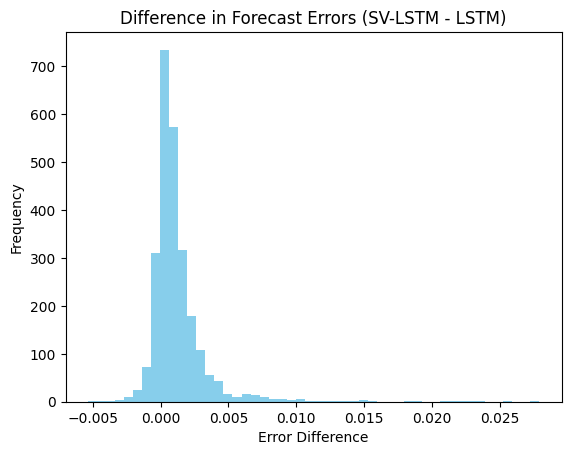

In [22]:
import matplotlib.pyplot as plt

plt.hist(error_diff, bins=50, color='skyblue')
plt.title('Difference in Forecast Errors (SV-LSTM - LSTM)')
plt.xlabel('Error Difference')
plt.ylabel('Frequency')
plt.show()

In [23]:
def diebold_mariano(e1, e2, h=1, power=2):
    """
    e1, e2: forecast errors from two models
    h: forecast horizon
    power: loss function power (2 = MSE, 1 = MAE)
    """
    d = np.abs(e1) ** power - np.abs(e2) ** power  # loss differential
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    DM_stat = mean_d / np.sqrt((var_d / len(d)))
    p_value = 2 * stats.norm.cdf(-abs(DM_stat))
    return DM_stat, p_value

In [39]:
# Apply Diebold-Mariano test
dm_stat, dm_p = diebold_mariano(error_lstm, error_sv, h=1, power=2)
print(f"Diebold-Mariano statistic(MSE): {dm_stat:.4f}, p-value: {dm_p:.8f}")

Diebold-Mariano statistic(MSE): -8.9440, p-value: 0.00000000


In [25]:
ks_stat, ks_p = stats.ks_2samp(y_pred_sv, y_pred_lstm)
print(f"Kolmogorov-Smirnov statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")

Kolmogorov-Smirnov statistic: 0.0610, p-value: 0.0002


In [36]:
# Apply Diebold-Mariano test
dm_stat3, dm_p3 = diebold_mariano(error_lstm, error_sv, h=1, power=1)
print(f"Diebold-Mariano statistic: {dm_stat3:.4f}, p-value: {dm_p3:.8f}")

Diebold-Mariano statistic: -27.5759, p-value: 0.00000000


In [37]:
dm_stat4, dm_p4 = diebold_mariano(error_lstm, error_sv, h=1, power=1)  # Absolute error
print(f"DM Statistic (MAE): {dm_stat4:.4f}, P-value: {dm_p4:.8f}")


DM Statistic (MAE): -27.5759, P-value: 0.00000000


In [28]:
dm_test, dm_p2 = dm_test(y_true, y_pred_sv, y_pred_lstm, one_sided=False)
print(f"Diebold-Mariano Test Statistic: {dm_test}")
print(f"P-value: {dm_p2}")

Diebold-Mariano Test Statistic: 8.943986306515123
P-value: 7.064641263795007e-19


In [29]:
mse_lstm = np.mean((y_true - y_pred_lstm) ** 2)
mse_sv_lstm = np.mean((y_true - y_pred_sv) ** 2)
print(f"MSE LSTM: {mse_lstm}, MSE SV-LSTM: {mse_sv_lstm}")


MSE LSTM: 7.087086163682974e-07, MSE SV-LSTM: 8.718939336059138e-06


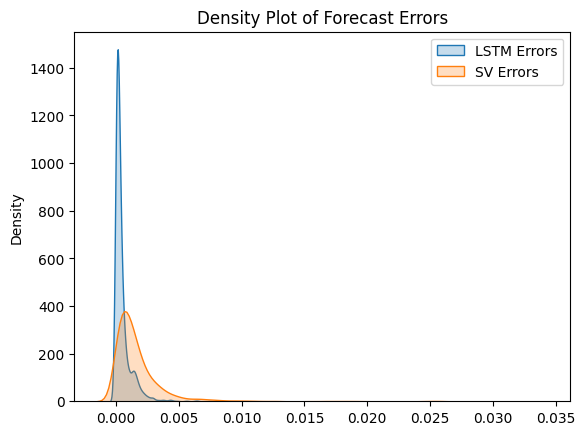

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(error_lstm, label="LSTM Errors", fill=True)
sns.kdeplot(error_sv, label="SV Errors", fill=True)
plt.legend()
plt.title("Density Plot of Forecast Errors")
plt.show()


In [33]:

# Define functions
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Compute error metrics
mse_lstm = mse(y_true, y_pred_lstm)
mae_lstm = mae(y_true, y_pred_lstm)
mape_lstm = mape(y_true, y_pred_lstm)

mse_sv_lstm = mse(y_true, y_pred_sv)
mae_sv_lstm = mae(y_true, y_pred_sv)
mape_sv_lstm = mape(y_true, y_pred_sv)

# Display results in scientific notation

def sci_format(val):
    return f"{val:.2e}".replace("e-0", "e-").replace("e+", "e")

def format_as_10(val):
    # Convert to scientific notation like: 1.29 * 10^(-5)
    base, exp = f"{val:.2e}".split('e')
    return f"{base} × 10^{int(exp)}"

# Display results
print("LSTM Model:")
print(f"MSE: {format_as_10(mse_lstm)}")
print(f"MAE: {format_as_10(mae_lstm)}")
print(f"MAPE: {(mape_lstm)}")


print("\nSV Model:")
print(f"MSE: {format_as_10(mse_sv_lstm)}")
print(f"MAE: {format_as_10(mae_sv_lstm)}")
print(f"MAPE: {(mape_sv_lstm)}")

LSTM Model:
MSE: 7.09 × 10^-7
MAE: 4.80 × 10^-4
MAPE: 5.290680302068335

SV Model:
MSE: 8.72 × 10^-6
MAE: 1.72 × 10^-3
MAPE: 18.090154473560098
